In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Customizing visualization
%matplotlib inline
sns.set_theme(style="whitegrid")


In [2]:
pd.options.display.max_columns = 150

train = pd.read_csv('./input/conjunto_de_treinamento.csv')
test = pd.read_csv('./input/conjunto_de_teste.csv')


## Analisando o conjunto de treinamento

In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id_solicitante                    20000 non-null  int64  
 1   produto_solicitado                20000 non-null  int64  
 2   dia_vencimento                    20000 non-null  int64  
 3   forma_envio_solicitacao           20000 non-null  object 
 4   tipo_endereco                     20000 non-null  int64  
 5   sexo                              20000 non-null  object 
 6   idade                             20000 non-null  int64  
 7   estado_civil                      20000 non-null  int64  
 8   qtde_dependentes                  20000 non-null  int64  
 9   grau_instrucao                    20000 non-null  int64  
 10  nacionalidade                     20000 non-null  int64  
 11  estado_onde_nasceu                20000 non-null  object 
 12  esta

In [4]:
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id_solicitante                    5000 non-null   int64  
 1   produto_solicitado                5000 non-null   int64  
 2   dia_vencimento                    5000 non-null   int64  
 3   forma_envio_solicitacao           5000 non-null   object 
 4   tipo_endereco                     5000 non-null   int64  
 5   sexo                              5000 non-null   object 
 6   idade                             5000 non-null   int64  
 7   estado_civil                      5000 non-null   int64  
 8   qtde_dependentes                  5000 non-null   int64  
 9   grau_instrucao                    5000 non-null   int64  
 10  nacionalidade                     5000 non-null   int64  
 11  estado_onde_nasceu                5000 non-null   object 
 12  estado

O conjunto de variáveis possui 41 colunas sendo:
  - 20 int64
  - 8 float64
  - 11 object

O conjunto de testes é semelhante, possuindo apenas a variável alvo: *inadimplentes*.
Na etapa de processamento dos dados devemos levar em conta alguns fatores:
  - O conjunto de testes é balanceado?
  - As variáveis numéricas estão representando valores booleanos (0 ou 1) ou são variáveis ordinárias discretas?
  - O que representam os valores de *object*? Provavelmente não podem ser passados diretamente para nossos modelos e, portanto, devem ser tratados previamente.
  - Qual o percentual de valores nulos e o que fazer caso ocorram?

## Balanceamento do conjunto

Um conjunto é considerado balanceado quando a distribuição das variáveis alvo são aproximados, ou seja, as classes (num problema de classificação), estão igualmente distribuidas.

In [5]:
def plot_value_counts(df, col):
    df_label = df[col].value_counts()
    plt = sns.barplot(x=df_label.index, y=df_label.values)
    plt.set(title=f"Value Counts for '{col}'", xlabel=f"{col}", ylabel="Count")


def plot_distribution_by_target(df, col, match=None, ax=None):
    if match is not None:
        df_labels = df[df[col] == match]
    elif type(match) == np.nan:
        df_labels = df[col].isna()
    else:
        df_labels = df[col]
    label_counts = df_labels['inadimplente'].value_counts().sort_index()
    if ax is None:
        sns.barplot(x=label_counts.index, y=label_counts.values)
        return
    else:
        sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax)


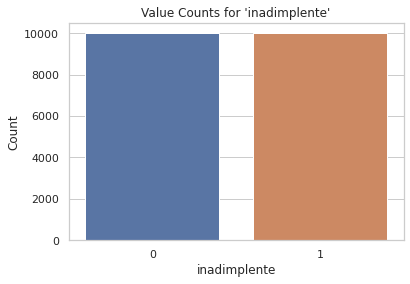

In [6]:
# train['inadimplente'].describe()
plot_value_counts(train, 'inadimplente')


Portanto, podemos afirmar que o nosso conjunto de dados é balanceado.

### Variáveis numéricas: booleanos ou ordinárias?

É possível responder essa questão com uma simples contagem de valores únicos através das tabelas.

[Text(0.5, 1.0, 'Contagem de valores únicos nas variáveis'),
 Text(0.5, 0, 'Número de valores únicos'),
 Text(0, 0.5, 'Contagem')]

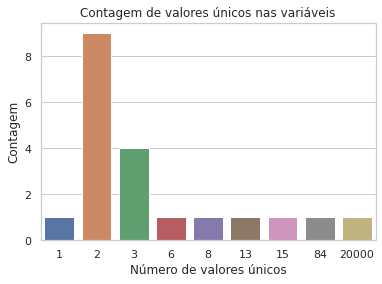

In [7]:
nuniques_int64 = train.select_dtypes(
    np.int64).nunique().value_counts().sort_index()

ax = sns.barplot(x=nuniques_int64.index, y=nuniques_int64.values)

ax.set(title="Contagem de valores únicos nas variáveis",
       xlabel="Número de valores únicos",
       ylabel="Contagem")


As colunas com apenas 2 valores representam booleanos (0 ou 1).
Podemos notar também que o código pegou a identificação de cada registro, por isso o salto para 20000 valores únicos.
Além disso, existe uma coluna que possui apenas um valor.

In [8]:
train.select_dtypes(np.int64).nunique().sort_values(ascending=True)


grau_instrucao                         1
possui_email                           2
possui_carro                           2
possui_outros_cartoes                  2
possui_cartao_amex                     2
possui_cartao_diners                   2
possui_cartao_mastercard               2
possui_cartao_visa                     2
inadimplente                           2
tipo_endereco                          2
qtde_contas_bancarias                  3
qtde_contas_bancarias_especiais        3
produto_solicitado                     3
nacionalidade                          3
dia_vencimento                         6
estado_civil                           8
meses_no_trabalho                     13
qtde_dependentes                      15
idade                                 84
id_solicitante                     20000
dtype: int64

Como a coluna 'grau_instrucao' possui um valor apenas em todo os registros, podemos desconsiderá-la.

In [9]:
for df in [train, test]:
    df.drop(columns=['grau_instrucao'], axis=1, inplace=True)


### Variáveis do tipo object

Podemos encontrar quais são as variáveis do tipo *object* da seguinte forma:

In [10]:
train.select_dtypes(object).head()


,forma_envio_solicitacao,sexo,estado_onde_nasceu,estado_onde_reside,possui_telefone_residencial,codigo_area_telefone_residencial,possui_telefone_celular,vinculo_formal_com_empresa,estado_onde_trabalha,possui_telefone_trabalho,codigo_area_telefone_trabalho
0,presencial,M,CE,CE,Y,107,N,N,,N,
1,internet,F,SE,SE,Y,91,N,N,,N,
2,internet,F,BA,BA,Y,90,N,N,,N,
3,internet,M,RS,RS,Y,54,N,Y,RS,Y,54
4,internet,F,BA,BA,Y,86,N,Y,BA,N,


In [11]:
print(train.select_dtypes(object).shape)


(20000, 11)


As seguintes variáveis apresentam valores binários:
- 'forma_envio_solicitacao'
- 'sexo'
- 'possui_telefone_residencial'
- 'possui_telefone_celular'
- 'vinculo_formal_com_empresa'
- 'possui_telefone_trabalho'

Enquanto as colunas 'codigo_area_telefone_residencial' e 'codigo_area_telefone_trabalho' deveriam ser convertidos para int64.

Os valores serão tratados utilizando a seguinte raciocínio:
- "Y" e "M" = 1
- "N" e "F" = 0
Mas para isso, precisamos validar quais são os valores únicos presentes nessas colunas e como estão distribuidos.

In [12]:
convert_to_int64 = ['codigo_area_telefone_residencial',
                    'codigo_area_telefone_trabalho']
# train[convert_to_int64[0]] = pd.to_numeric(train[convert_to_int64[0]], errors='ignore')
for df in [train, test]:
    for col in convert_to_int64:
        df[col] = pd.to_numeric(df[col], errors='coerce')


Y    16474
N     3526
Name: possui_telefone_residencial, dtype: int64
N    20000
Name: possui_telefone_celular, dtype: int64
N    11174
Y     8826
Name: vinculo_formal_com_empresa, dtype: int64
N    14519
Y     5481
Name: possui_telefone_trabalho, dtype: int64
F    12246
M     7722
N       25
         7
Name: sexo, dtype: int64
internet      11264
presencial     7855
correio         881
Name: forma_envio_solicitacao, dtype: int64


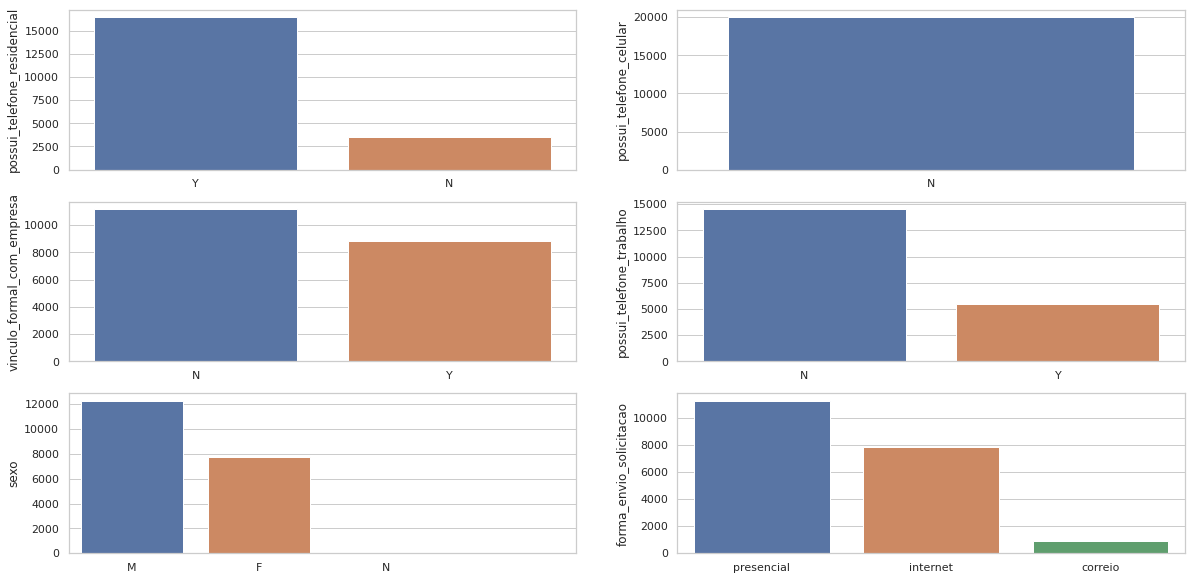

In [13]:
y_or_n_cols = ['possui_telefone_residencial', 'possui_telefone_celular',
               'vinculo_formal_com_empresa', 'possui_telefone_trabalho']
gender_col = ['sexo']
req_type_cols = ['forma_envio_solicitacao']

check_unique_values = y_or_n_cols + gender_col + req_type_cols

fig, ax = plt.subplots(figsize=(20, 10), nrows=3, ncols=2)

for i, col in enumerate(check_unique_values):
    unique_values = train[col].unique()
    unique_value_counts = train[col].value_counts()
    print(f"{unique_value_counts}")
    sns.barplot(x=unique_values, y=unique_value_counts, ax=ax[int(i/2), i % 2])


Essa visualização trazem três pontos interessantes:
- A função aponta que na coluna 'sexo', devem ser considerados os casos 'N' e ' '. Como são poucos registros, podemos desconsiderar esses valores para reduzir a complexidade da variável.
- Todos os registros não possuem telefone celular, o que significa que esse valor não vai impactar na decisão do modelo e pode ser rejeitado.
- As formas de envio da solicitação possui um valor muito baixo como 'correios'. Isso pode ser analisado melhor na distribuição dessa variável com a nossa variável alvo.

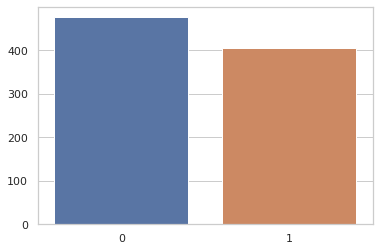

In [14]:
plot_distribution_by_target(train, 'forma_envio_solicitacao', 'correio')


Os valores estão balanceados mas serão mantidos no conjunto.

In [15]:
# Drop "N" and " " values from 'sexo'
train = train.drop(train[(train['sexo'] == " ") |
                   (train['sexo'] == "N")].index)

# Drop 'possui_telefone_celular'
y_or_n_cols.remove('possui_telefone_celular')
check_unique_values.remove('possui_telefone_celular')
train = train.drop(columns='possui_telefone_celular')
test = test.drop(columns='possui_telefone_celular')


In [16]:
print(train.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19968 entries, 0 to 19999
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id_solicitante                    19968 non-null  int64  
 1   produto_solicitado                19968 non-null  int64  
 2   dia_vencimento                    19968 non-null  int64  
 3   forma_envio_solicitacao           19968 non-null  object 
 4   tipo_endereco                     19968 non-null  int64  
 5   sexo                              19968 non-null  object 
 6   idade                             19968 non-null  int64  
 7   estado_civil                      19968 non-null  int64  
 8   qtde_dependentes                  19968 non-null  int64  
 9   nacionalidade                     19968 non-null  int64  
 10  estado_onde_nasceu                19968 non-null  object 
 11  estado_onde_reside                19968 non-null  object 
 12  poss

In [17]:
print(test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id_solicitante                    5000 non-null   int64  
 1   produto_solicitado                5000 non-null   int64  
 2   dia_vencimento                    5000 non-null   int64  
 3   forma_envio_solicitacao           5000 non-null   object 
 4   tipo_endereco                     5000 non-null   int64  
 5   sexo                              5000 non-null   object 
 6   idade                             5000 non-null   int64  
 7   estado_civil                      5000 non-null   int64  
 8   qtde_dependentes                  5000 non-null   int64  
 9   nacionalidade                     5000 non-null   int64  
 10  estado_onde_nasceu                5000 non-null   object 
 11  estado_onde_reside                5000 non-null   object 
 12  possui

In [18]:
y_or_n_mapping = {"Y": 1.0, "N": 0.0}
gender_mapping = {"F": 0, "M": 1, " ": 2, "N": 2}
req_type_mapping = {"presencial": 0, "internet": 1, "correio": 3}

# The mapping should be applied to both train and test datasets:
for df in [train, test]:
    for col in y_or_n_cols:
        df[col] = df[col].replace(y_or_n_mapping).astype(np.int64)
    for col in req_type_cols:
        df[col] = df[col].replace(req_type_mapping).astype(np.int64)
    df['sexo'] = df['sexo'].replace(gender_mapping).astype(np.int64)

train[check_unique_values].describe()
train[check_unique_values].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19968 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   possui_telefone_residencial  19968 non-null  int64
 1   vinculo_formal_com_empresa   19968 non-null  int64
 2   possui_telefone_trabalho     19968 non-null  int64
 3   sexo                         19968 non-null  int64
 4   forma_envio_solicitacao      19968 non-null  int64
dtypes: int64(5)
memory usage: 936.0 KB


In [19]:
train['sexo'].unique()


array([1, 0])

Para os colunas com estados, a abordagem será parecida:
- 'estado_onde_nasceu'
- 'estado_onde_reside'
- 'estado_onde_trabalha'

In [20]:
states_mapping = {
    "AC": 0,
    "AL": 1,
    "AP": 2,
    "AM": 3,
    "BA": 4,
    "CE": 5,
    "ES": 6,
    "GO": 7,
    "MA": 8,
    "MT": 9,
    "MS": 10,
    "MG": 11,
    "PA": 12,
    "PB": 13,
    "PR": 14,
    "PI": 15,
    "PE": 16,
    "RJ": 17,
    "RN": 18,
    "RS": 19,
    "RO": 20,
    "RR": 21,
    "SC": 22,
    "SP": 23,
    "SE": 24,
    "TO": 25,
    "DF": 26,
    " ": 27,
}

state_columns = ['estado_onde_nasceu',
                 'estado_onde_reside', 'estado_onde_trabalha']

for df in [train, test]:
    for col in state_columns:
        df[col] = df[col].replace(states_mapping, method=None)


train[state_columns].describe()


,estado_onde_nasceu,estado_onde_reside,estado_onde_trabalha
count,19968.000000,19968.000000,19968.000000
mean,13.214493,13.531300,22.676182
std,7.473310,7.274176,7.469657
min,0.000000,0.000000,0.000000
25%,5.000000,6.000000,19.000000
50%,14.000000,14.000000,27.000000
75%,19.000000,19.000000,27.000000
max,27.000000,26.000000,27.000000


Com isso, falta podemos checar se ainda restam tipos *object*.

In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id_solicitante                    5000 non-null   int64  
 1   produto_solicitado                5000 non-null   int64  
 2   dia_vencimento                    5000 non-null   int64  
 3   forma_envio_solicitacao           5000 non-null   int64  
 4   tipo_endereco                     5000 non-null   int64  
 5   sexo                              5000 non-null   int64  
 6   idade                             5000 non-null   int64  
 7   estado_civil                      5000 non-null   int64  
 8   qtde_dependentes                  5000 non-null   int64  
 9   nacionalidade                     5000 non-null   int64  
 10  estado_onde_nasceu                5000 non-null   int64  
 11  estado_onde_reside                5000 non-null   int64  
 12  possui

In [22]:
def check_object_columns(df, name):
    print(
        f"O conjunto {name} possui {df.select_dtypes(object).shape[1]} colunas do tipo object.")


check_object_columns(train, 'train')
check_object_columns(test, 'test')


O conjunto train possui 0 colunas do tipo object.
O conjunto test possui 0 colunas do tipo object.


### Valores faltantes
Além disso, é necessário checar qual o percentual dos valores faltantes em cada coluna e se preciso, preencher os valores.

Os conjuntos de teste e treino são unidos de forma temporária para que o tratamento dos valores seja feito de forma consistente.

In [23]:
test['inadimplente'] = np.nan
data = pd.concat([train, test], ignore_index=True)


In [24]:
# Number of missing data in each column
def find_missing_percentage(df):
    missing = pd.DataFrame(df.isnull().sum()).rename(columns={0: 'total'})

    # Percentage missing
    missing['percent'] = missing['total'] / len(data)
    print(missing.sort_values('percent', ascending=False).head(
        11).drop('inadimplente'))

find_missing_percentage(data)


                                  total   percent
codigo_area_telefone_trabalho     18164  0.727491
grau_instrucao_companheiro        16069  0.643584
profissao_companheiro             14401  0.576778
codigo_area_telefone_residencial   4350  0.174223
profissao                          3859  0.154558
ocupacao                           3668  0.146908
meses_na_residencia                1812  0.072573
tipo_residencia                     661  0.026474
qtde_contas_bancarias                 0  0.000000
qtde_contas_bancarias_especiais       0  0.000000


Deveremos lidar com cada uma das variáveis de forma individual para descobrir qual será o melhor tratamento.

In [25]:
missing_cols = ['codigo_area_telefone_trabalho', 'estado_onde_trabalha', 'grau_instrucao_companheiro', 'profissao_companheiro',
                'codigo_area_telefone_residencial', 'profissao', 'ocupacao', 'meses_na_residencia', 'estado_onde_nasceu', 'tipo_residencia']


As colunas que estão faltando mais informações, podem ser casos em que os indivíduos não possuem trabalho ou companheiros, por isso as informações não são declaradas, portanto essas colunas podem ser descartadas.

In [26]:
to_drop = ['codigo_area_telefone_trabalho', 'grau_instrucao_companheiro',
           'profissao_companheiro', 'codigo_area_telefone_residencial']
data = data.drop(columns=to_drop)
for col in to_drop:
    missing_cols.remove(col)


In [27]:
missing_cols


['estado_onde_trabalha',
 'profissao',
 'ocupacao',
 'meses_na_residencia',
 'estado_onde_nasceu',
 'tipo_residencia']

In [28]:
find_missing_percentage(data)


                                 total   percent
profissao                         3859  0.154558
ocupacao                          3668  0.146908
meses_na_residencia               1812  0.072573
tipo_residencia                    661  0.026474
valor_patrimonio_pessoal             0  0.000000
possui_cartao_amex                   0  0.000000
possui_outros_cartoes                0  0.000000
qtde_contas_bancarias                0  0.000000
qtde_contas_bancarias_especiais      0  0.000000
vinculo_formal_com_empresa           0  0.000000


Para lida com as variáveis categóricas 'ocupacao' e 'profissao' e 'tipo_residencia', podemos criar uma nova categoria para preencher os valores, que funcionará como 'não_identificado'.
No caso da coluna 'meses_na_residencia', os valores faltantes serão convertidos para 0.

In [29]:
# Fill missing values
def add_new_category_to_fill_null(df, col):
    df[col] = df[col].fillna(df[col].max() + 1)


for col in ['ocupacao', 'profissao', 'tipo_residencia']:
    add_new_category_to_fill_null(data, col)

data['meses_na_residencia'] = data['meses_na_residencia'].fillna(0)


In [30]:
find_missing_percentage(data)


                                 total  percent
produto_solicitado                   0      0.0
possui_cartao_diners                 0      0.0
possui_cartao_amex                   0      0.0
possui_outros_cartoes                0      0.0
qtde_contas_bancarias                0      0.0
qtde_contas_bancarias_especiais      0      0.0
valor_patrimonio_pessoal             0      0.0
possui_carro                         0      0.0
vinculo_formal_com_empresa           0      0.0
estado_onde_trabalha                 0      0.0


Agora o conjunto não possui mais valores faltantes.

### Correlação das variáveis
Podemos checar qual o grau de correlação dessas variáveis através de uma matriz de correlação e descobrir se há variáveis redundantes.

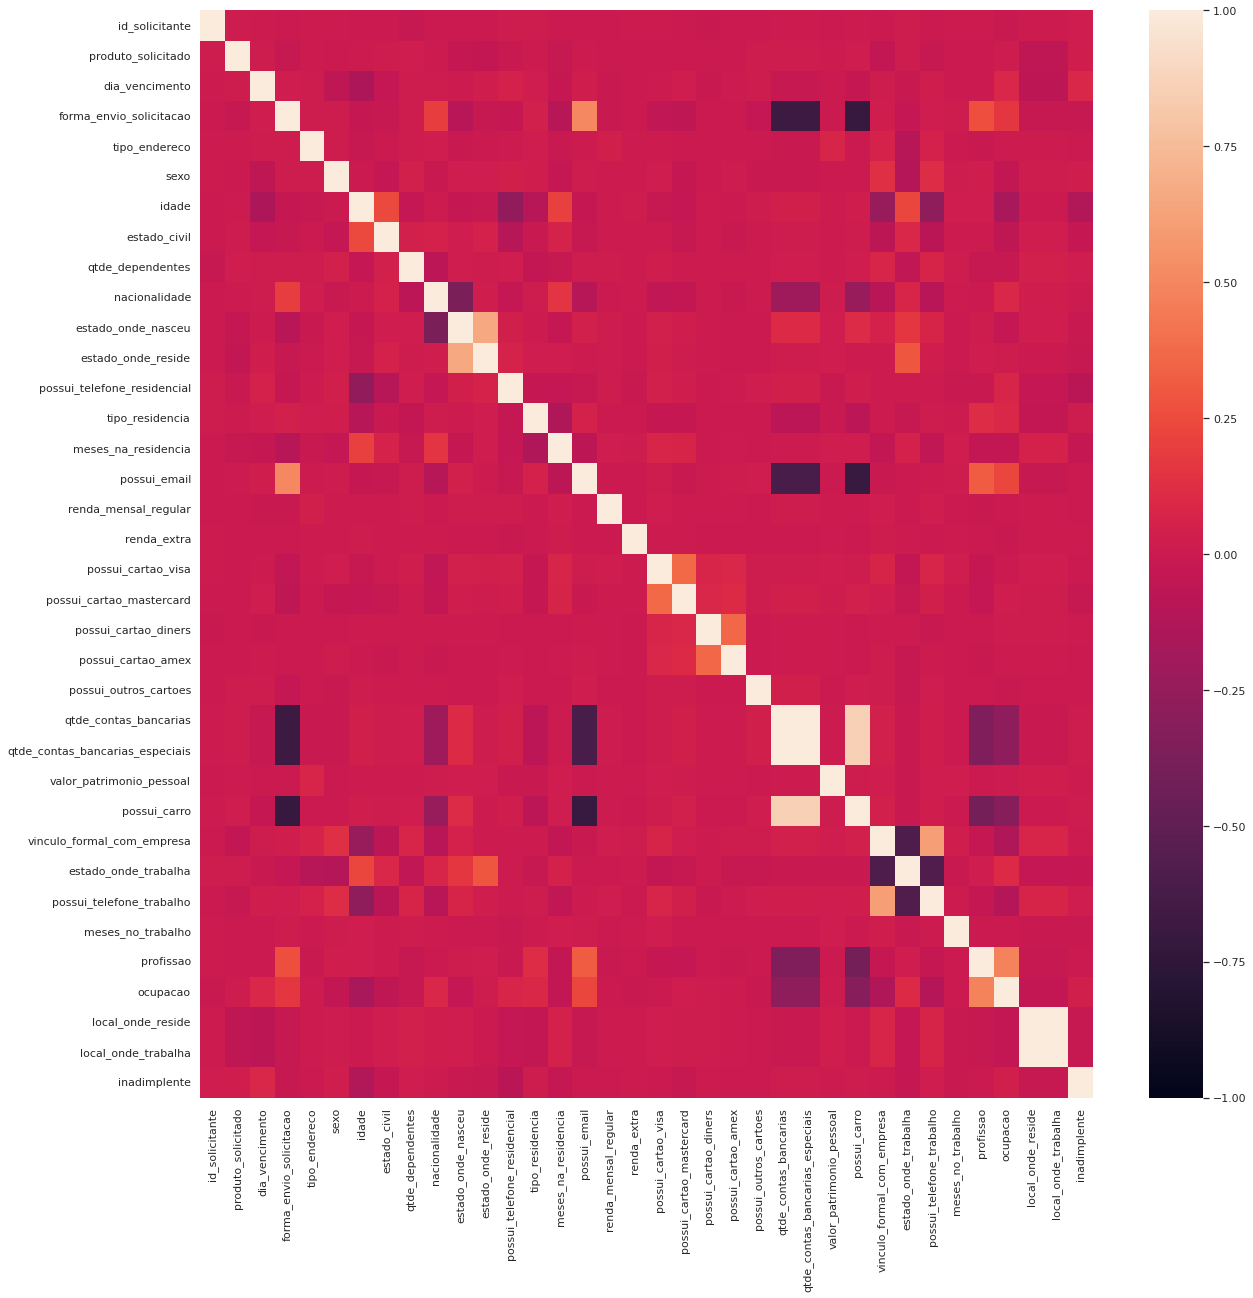

In [31]:
def plot_corr_matrix(corr_matrix):
    fig, ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(data=corr_matrix, ax=ax, vmin=-1.0, vmax=1.0)


corr_matrix = data.corr()
plot_corr_matrix(corr_matrix)


A matriz mostra alguns valores bem próximos de 1, mas existe uma forma melhor de filtrar quais são as variáveis que possuem a correlação acima de um limiar e então, removê-las.

In [32]:
def find_correlation_above_threshold(matrix, threshold=0.95):
    upper = matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(bool))
    # Find index of feature columns with correlation greater than 0.95
    corr_above_threshold = [column for column in upper.columns if any(
        abs(upper[column]) > threshold)]
    return corr_above_threshold


to_drop = find_correlation_above_threshold(corr_matrix)
to_drop


['qtde_contas_bancarias_especiais', 'local_onde_trabalha']

In [33]:
data = data.drop(columns=to_drop)

## Modelos

In [34]:
from sklearn.metrics import accuracy_score, make_scorer

# Create scorer to evaluate model performance
scorer = make_scorer(accuracy_score, greater_is_better=True)

train_labels = np.array(list(data[data['inadimplente'].notnull()]['inadimplente'].astype(np.uint8)))
train_set = data[data['inadimplente'].notnull()].drop(columns= ['id_solicitante', 'inadimplente'])
test_set = data[data['inadimplente'].isnull()].drop(columns = ['id_solicitante', 'inadimplente'])

## Escalonamento

Para rodar alguns modelos, o ideal é escalar nossas variáveis.

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('scaler', MinMaxScaler())])

train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

## Rodando os modelos

In [36]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBM, RandomForestClassifier

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.simplefilter('ignore')

model_results = pd.DataFrame(columns=['model', 'params', 'cv_mean', 'cv_std', 'scaler'])

def cv_model(train_set, train_labels, model, params, name, model_results=None):
    clf = GridSearchCV(estimator=model,
                       scoring=scorer,
                       param_grid=params,
                       cv=10,
                       n_jobs=-1)
    clf.fit(train_set, train_labels)
    results = clf.cv_results_
    best_score = clf.best_score_
    best_score_std = results['std_test_score'][clf.best_index_]
    best_params = str(clf.best_params_)
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name,
                                                           'params': [best_params],
                                                           'cv_mean': [best_score],
                                                           'cv_std': [best_score_std]
                                                           }))

    print(f"{name}: 10 Fold CV Score: {best_score} with std: {best_score_std}. params used = {best_params}")
    return model_results


In [38]:
model_results = cv_model(train_set, train_labels, LinearSVC(random_state=42),
                         {'C': [0.1, 1, 10],
                          'loss': ['hinge', 'square_hinge']},
                         'SVM', model_results)

/home/joao/.cache/pypoetry/virtualenvs/eel891-ml-iKDTWZY6-py3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/joao/.cache/pypoetry/virtualenvs/eel891-ml-iKDTWZY6-py3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/joao/.cache/pypoetry/virtualenvs/eel891-ml-iKDTWZY6-py3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/joao/.cache/pypoetry/virtualenvs/eel891-ml-iKDTWZY6-py3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/joao/.cache/pypoetry/virtualenvs/eel891-ml-iKDTWZY6-py3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:120

SVM: 10 Fold CV Score: 0.580830012553901 with std: 0.011654208609496043. params used = {'C': 10, 'loss': 'hinge'}


In [39]:
model_results = cv_model(train_set,
                         train_labels,
                         RandomForestClassifier(random_state=42, n_jobs=-1),
                         {'n_estimators': [10, 100, 200, 300, 400],
                          'criterion': ['gini', 'entropy']},
                         'RF',
                         model_results)

RF: 10 Fold CV Score: 0.5854360950243 with std: 0.009326441185255474. params used = {'criterion': 'gini', 'n_estimators': 400}


In [40]:
model_results = cv_model(train_set,
                         train_labels,
                         DecisionTreeClassifier(random_state=42),
                         {'criterion': ['gini', 'entropy']},
                         'DT',
                         model_results)

DT: 10 Fold CV Score: 0.5337047906529133 with std: 0.0071474723908473625. params used = {'criterion': 'entropy'}


In [41]:
model_results = cv_model(train_set,
                         train_labels,
                         GBM(random_state=42),
                         {'n_estimators': [10, 100],
                          'n_iter_no_change': [5, 10, 15],
                          'learning_rate': [0.001, 0.01, 0.1],
                          'tol': [0.01, 0.1],
                          'subsample': [0.1, 0.3, 0.5, 0.7, 1.0]},
                         'GBM',
                         model_results)

GBM: 10 Fold CV Score: 0.5879410297811447 with std: 0.007920582044985025. params used = {'learning_rate': 0.1, 'n_estimators': 100, 'n_iter_no_change': 10, 'subsample': 0.3, 'tol': 0.01}


In [42]:
model_results = cv_model(train_set,
                         train_labels,
                         KNeighborsClassifier(n_jobs=-1),
                         {'n_neighbors': [5, 10, 15]},
                         'KNN',
                         model_results)

KNN: 10 Fold CV Score: 0.5413162328663336 with std: 0.01179076710121587. params used = {'n_neighbors': 15}


Text(0, 0.5, 'Mean Accuracy Score w/ error bar')

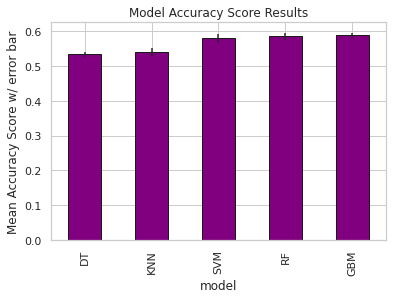

In [43]:
model_results = model_results.set_index('model')
model_results = model_results.sort_values(by='cv_mean', ascending=True)
model_results['cv_mean'].plot.bar(color = 'purple', yerr = list(model_results['cv_std']), edgecolor = 'k')
plt.title('Model Accuracy Score Results')
plt.ylabel('Mean Accuracy Score w/ error bar')

Pelo gráfico, o melhor modelo foi o GBM. Portanto, o que resta é encontrar os parâmetros encontrados pelo GridSearch e rodar o modelo para o conjunto de testes. Após isso, exportar a solução.

In [44]:
import ast
dict = ast.literal_eval(model_results['params']['GBM'])

In [45]:
def create_submission(model, train, train_labels, test, test_ids):
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'id_solicitante': test_ids,
                                'inadimplente': predictions})

    return predictions

In [46]:
test_ids = test['id_solicitante']

In [47]:
params = ast.literal_eval(model_results['params']['GBM'])
submission = create_submission(GBM(random_state=42, **params), train_set, train_labels, test_set, test_ids)
print(submission)
submission.describe()
submission.to_csv('./output/gbm.csv', index=False)

      id_solicitante  inadimplente
0              20001             1
1              20002             1
2              20003             1
3              20004             0
4              20005             0
...              ...           ...
4995           24996             1
4996           24997             1
4997           24998             1
4998           24999             1
4999           25000             0

[5000 rows x 2 columns]
